In [1]:
%load_ext autoreload
%autoreload 2

# Potential Outcome Model

This lecture introduces the potential outcome framework for causal inference using a simulated online retail dataset. Our running example: **Does improving product content quality increase sales?** We use a static (cross-sectional) setup where each product has a single outcome observation. This simplifies the exposition while preserving all key concepts.

## Setup

In [31]:
pip install -qq --force-reinstall git+https://github.com/eisenhauerIO/tools-catalog-generator.git

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.42.30 requires botocore==1.40.30, but you have botocore 1.42.9 which is incompatible.
awscli 1.42.30 requires docutils<=0.19,>=0.18.1, but you have docutils 0.21.2 which is incompatible.
awscli 1.42.30 requires s3transfer<0.15.0,>=0.14.0, but you have s3transfer 0.16.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import Code
import inspect
from operator import itemgetter
import numpy as np

from online_retail_simulator import simulate, load_job_results
from online_retail_simulator.enrich import enrich

from support import (
    plot_individual_effects_distribution,
    plot_treatment_parameters,
    plot_bias_decomposition,
    plot_randomization_comparison,
    plot_bootstrap_distribution,
    plot_outcome_by_treatment,
    plot_balance_check,
    generate_quality_score,
)

np.random.seed(42)

### Generate Baseline Data

We simulate 500 products with a single day of sales data. This gives us cross-sectional data: one revenue observation per product.

In [3]:
print(open("config_simulation.yaml").read())

STORAGE:
  PATH: output

RULE:
  CHARACTERISTICS:
    FUNCTION: simulate_characteristics_rule_based
    PARAMS:
      num_products: 500
      seed: 42

  METRICS:
    FUNCTION: simulate_metrics_rule_based
    PARAMS:
      date_start: "2024-11-15"
      date_end: "2024-11-15"
      sale_prob: 0.7
      seed: 42

PRODUCT_DETAILS:
  FUNCTION: simulate_product_details_mock



In [4]:
# Run simulation
job_info = simulate("config_simulation.yaml")
products, sales = itemgetter("products", "sales")(load_job_results(job_info))

print(f"Products: {len(products)}")
print(f"Sales records: {len(sales)}")
print(f"Date: {sales['date'].unique()[0]}")

Products: 500
Sales records: 500
Date: 2024-11-15


### Enrichment Configuration

The simulator provides an enrichment pipeline for applying treatment effects. Here's the configuration for random treatment assignment:

In [5]:
print(open("config_enrichment_random.yaml").read())

IMPACT:
  FUNCTION: quantity_boost
  PARAMS:
    effect_size: 0.5
    enrichment_fraction: 0.3
    enrichment_start: "2024-11-15"
    seed: 42



In [6]:
from online_retail_simulator.enrich.enrichment_library import quantity_boost

Code(inspect.getsource(quantity_boost), language="python")

def quantity_boost(sales: list, **kwargs) -> tuple:
    """
    Boost ordered units by a percentage for enriched products.

    Args:
        sales: List of sale transaction dictionaries
        **kwargs: Parameters including:
            - effect_size: Percentage increase in ordered units (default: 0.5 for 50% boost)
            - enrichment_fraction: Fraction of products to enrich (default: 0.3)
            - enrichment_start: Start date of enrichment (default: "2024-11-15")
            - seed: Random seed for product selection (default: 42)
            - min_units: Minimum units for enriched products with zero sales (default: 1)

    Returns:
        Tuple of (treated_sales, potential_outcomes_df):
            - treated_sales: List of modified sale dictionaries with treatment applied
            - potential_outcomes_df: DataFrame with Y0_revenue and Y1_revenue for all products
    """
    effect_size = kwargs.get("effect_size", 0.5)
    enrichment_fraction = kwargs.get("enrichment_fraction", 0.3)
    enrichment_start = kwargs.get("enrichment_start", "2024-11-15")
    seed = kwargs.get("seed", 42)
    min_units = kwargs.get("min_units", 1)

    if seed is not None:
        random.seed(seed)

    unique_products = list(set(sale["product_id"] for sale in sales))
    n_enriched = int(len(unique_products) * enrichment_fraction)
    enriched_product_ids = set(random.sample(unique_products, n_enriched))

    treated_sales = []
    potential_outcomes = {}  # {(product_id, date): {'Y0_revenue': x, 'Y1_revenue': y}}
    start_date = datetime.strptime(enrichment_start, "%Y-%m-%d")

    for sale in sales:
        sale_copy = copy.deepcopy(sale)
        product_id = sale_copy["product_id"]
        sale_date_str = sale_copy["date"]
        sale_date = datetime.strptime(sale_date_str, "%Y-%m-%d")

        is_enriched = product_id in enriched_product_ids
        sale_copy["enriched"] = is_enriched

        # Calculate Y(0) - baseline revenue (no treatment)
        y0_revenue = sale_copy["revenue"]

        # Calculate Y(1) - revenue if treated (for ALL products)
        unit_price = sale_copy.get("unit_price", sale_copy.get("price"))
        if sale_date >= start_date:
            original_quantity = sale_copy["ordered_units"]
            boosted_quantity = int(original_quantity * (1 + effect_size))
            boosted_quantity = max(min_units, boosted_quantity)
            y1_revenue = round(boosted_quantity * unit_price, 2)
        else:
            # Before treatment start, Y(1) = Y(0)
            y1_revenue = y0_revenue

        # Store potential outcomes for ALL products
        key = (product_id, sale_date_str)
        potential_outcomes[key] = {"Y0_revenue": y0_revenue, "Y1_revenue": y1_revenue}

        # Apply factual outcome (only for treated products)
        if is_enriched and sale_date >= start_date:
            sale_copy["ordered_units"] = boosted_quantity
            sale_copy["revenue"] = y1_revenue

        treated_sales.append(sale_copy)

    # Build potential outcomes DataFrame
    potential_outcomes_df = pd.DataFrame(
        [
            {
                "product_identifier": pid,
                "date": d,
                "Y0_revenue": v["Y0_revenue"],
                "Y1_revenue": v["Y1_revenue"],
            }
            for (pid, d), v in potential_outcomes.items()
        ]
    )

    return treated_sales, potential_outcomes_df

In [7]:
# Apply random treatment using enrichment pipeline
enrich("config_enrichment_random.yaml", job_info)

products, sales, sales_enriched = itemgetter("products", "sales", "enriched")(
    load_job_results(job_info)
)
print(f"Baseline revenue: ${sales['revenue'].sum():,.0f}")
print(f"Enriched revenue: ${sales_enriched['revenue'].sum():,.0f}")

Baseline revenue: $18,703
Enriched revenue: $49,984


In [8]:
df = sales[
    ["product_identifier", "revenue", "ordered_units", "price", "category"]
].copy()
df.head(10)

,product_identifier,revenue,ordered_units,price,category
0,BRPOIG8F1C,0.00,0,19.63,Clothing
1,BO6B9M80O2,0.00,0,185.86,Electronics
2,BAK1VRJNVG,245.69,1,245.69,Sports & Outdoors
3,BWWQC38HYF,0.00,0,85.29,Clothing
4,BXMECOSFOG,0.00,0,251.38,Sports & Outdoors
5,BXKXWNREK8,0.00,0,17.51,Food & Beverage
6,BYR9OUDOCU,0.00,0,18.17,Books
7,BNUN5Z3JQI,17.05,1,17.05,Food & Beverage
8,B8Q1ZXOI65,0.00,0,47.25,Books
9,BHJK1EYY37,774.10,5,154.82,Clothing


In [9]:
sales_enriched

,product_identifier,category,price,title,description,brand,features,date,impressions,visits,cart_adds,ordered_units,revenue,enriched
0,BRPOIG8F1C,Clothing,19.63,UrbanWear Casual Clothing Item,Quality clothing product for everyday use. Wri...,UrbanWear,"['Wrinkle resistant', 'Stretch fit', 'Quick dr...",2024-11-15,10,1,0,0,0.00,False
1,BO6B9M80O2,Electronics,185.86,NexGen Pro Electronics Item,Quality electronics product for everyday use. ...,NexGen,"['Fast charging', 'Voice control', 'LCD displa...",2024-11-15,0,0,0,1,185.86,True
2,BAK1VRJNVG,Sports & Outdoors,245.69,BestChoice Premium Sports & Outdoors Item,Quality sports & outdoors product for everyday...,BestChoice,"['High quality materials', 'Easy to use', 'Gre...",2024-11-15,100,12,2,1,245.69,False
3,BWWQC38HYF,Clothing,85.29,TrendyThreads Comfortable Clothing Item,Quality clothing product for everyday use. Wri...,TrendyThreads,"['Wrinkle resistant', 'Stretch fit', 'Breathab...",2024-11-15,25,3,0,0,0.00,False
4,BXMECOSFOG,Sports & Outdoors,251.38,PrimePick Premium Sports & Outdoors Item,Quality sports & outdoors product for everyday...,PrimePick,"['Durable construction', 'Great value', 'Long ...",2024-11-15,25,3,0,0,0.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,BE19ES4IHR,Toys & Games,90.78,ValueBrand Quality Toys & Games Item,Quality toys & games product for everyday use....,ValueBrand,"['Easy to use', 'Durable construction', 'Long ...",2024-11-15,50,8,1,0,0.00,False
496,B7NNDG7F4S,Toys & Games,57.43,PrimePick Classic Toys & Games Item,Quality toys & games product for everyday use....,PrimePick,"['Great value', 'High quality materials', 'Lon...",2024-11-15,0,0,0,1,57.43,True
497,BUQ7WI5755,Food & Beverage,32.40,PrimePick Premium Food & Beverage Item,Quality food & beverage product for everyday u...,PrimePick,"['Easy to use', 'High quality materials', 'Dur...",2024-11-15,25,4,0,0,0.00,False
498,BOSMAHB3HN,Home & Garden,444.16,PrimePick Premium Home & Garden Item,Quality home & garden product for everyday use...,PrimePick,"['Durable construction', 'Long lasting', 'High...",2024-11-15,0,0,0,1,444.16,True


## The Potential Outcome Framework

The potential outcome framework provides a precise language for defining causal effects. For each product $i$, we define:

- $D_i \in \{0, 1\}$: Treatment indicator (1 if product receives content optimization, 0 otherwise)
- $Y_i^1$: Potential outcome (revenue) if product $i$ receives optimization
- $Y_i^0$: Potential outcome (revenue) if product $i$ does not receive optimization

The **observed outcome** follows a switching equation:

$$Y_i = D_i \cdot Y_i^1 + (1 - D_i) \cdot Y_i^0$$

This means we only observe $Y_i^1$ for treated products and $Y_i^0$ for control products—never both.

## The Fundamental Problem of Causal Inference

Holland (1986) articulated the fundamental problem: **we cannot observe both potential outcomes for the same unit**. The counterfactual outcome is always missing.

| Product | Treatment | Observed | $Y^1$ | $Y^0$ |
|---------|-----------|----------|-------|-------|
| A | Treated | \$500 | \$500 | ? |
| B | Control | \$300 | ? | \$300 |
| C | Treated | \$450 | \$450 | ? |

The question marks represent the fundamental problem—we never observe what *would have happened* under the alternative treatment.

In [11]:
# Start with what we OBSERVE in sales_enriched
fundamental_df = sales_enriched[["product_identifier", "revenue", "enriched"]].copy()
fundamental_df.columns = ["Product", "Observed", "Treated"]

# Impute potential outcomes - we only observe ONE
fundamental_df["Y¹"] = np.where(
    fundamental_df["Treated"], fundamental_df["Observed"], np.nan
)
fundamental_df["Y⁰"] = np.where(
    ~fundamental_df["Treated"], fundamental_df["Observed"], np.nan
)

# Show products with positive revenue for clearer illustration
sample = fundamental_df[fundamental_df["Observed"] > 0].sample(8, random_state=42)
sample["Treated"] = sample["Treated"].map({True: "Yes", False: "No"})
sample[["Product", "Treated", "Observed", "Y¹", "Y⁰"]]

,Product,Treated,Observed,Y¹,Y⁰
331,BXAU7MBAPO,Yes,823.98,823.98,NaN
35,BHQLQCG1WU,Yes,94.53,94.53,NaN
395,BGBM760JGL,Yes,67.05,67.05,NaN
241,BJ6Y0IY1L5,Yes,48.86,48.86,NaN
179,BNM8R9RIGP,Yes,227.99,227.99,NaN
390,BOE6RNJLKX,No,231.15,NaN,231.15
139,B3EH58B6PJ,No,791.48,NaN,791.48
34,BZVRERW6Z8,Yes,1007.05,1007.05,NaN


### Define Potential Outcomes

We use the **actual simulator revenue** as $Y^0$ (the control potential outcome). The treatment effect $\delta$ depends on quality: high-quality products have less room to improve.

**Key assumption:** Treatment effect is **smaller** for high quality products (diminishing returns to optimization).

In [16]:
# Load all results including potential outcomes
results = load_job_results(job_info)
potential_outcomes = results["potential_outcomes"]

# Merge with enriched sales to get treatment indicator
full_info_df = potential_outcomes.merge(
    sales_enriched[["product_identifier", "enriched", "revenue"]],
    on="product_identifier",
)
full_info_df = full_info_df.rename(
    columns={
        "Y0_revenue": "Y⁰",
        "Y1_revenue": "Y¹",
        "enriched": "Treated",
        "revenue": "Y_obs",
    }
)

# Show sample with positive revenue
sample = full_info_df[full_info_df["Y⁰"] > 0].sample(8, random_state=42)
sample["Treated"] = sample["Treated"].map({True: "Yes", False: "No"})
sample[["product_identifier", "Treated", "Y_obs", "Y⁰", "Y¹"]]

,product_identifier,Treated,Y_obs,Y⁰,Y¹
152,BNS5MHIE2L,No,215.65,215.65,215.65
444,B5FVDDWJ8G,No,122.02,122.02,183.03
437,BBLGSRI2AO,No,4368.27,4368.27,5824.36
80,BST5J284WV,No,746.58,746.58,995.44
414,BWJGHF5A8C,No,155.46,155.46,207.28
22,BD8DUDD467,No,77.04,77.04,77.04
139,B3EH58B6PJ,No,791.48,791.48,1187.22
470,B8NN87Q94J,Yes,3187.32,2124.88,3187.32


## Individual Treatment Effects

The individual treatment effect for product $i$ is:

$$\delta_i = Y_i^1 - Y_i^0$$

This measures how much product $i$'s revenue would change due to content optimization.

**Simulator Advantage**: Unlike real data, we can compute true individual effects because we control the data generating process.

In [17]:
# Individual treatment effect
full_info_df["delta"] = full_info_df["Y¹"] - full_info_df["Y⁰"]


print("Individual Treatment Effects:")
print(f"  Mean: ${full_info_df['delta'].mean():,.2f}")
print(f"  Std:  ${full_info_df['delta'].std():,.2f}")
print(f"  Min:  ${full_info_df['delta'].min():,.2f}")
print(f"  Max:  ${full_info_df['delta'].max():,.2f}")

Individual Treatment Effects:
  Mean: $174.52
  Std:  $278.41
  Min:  $0.00
  Max:  $1,480.98


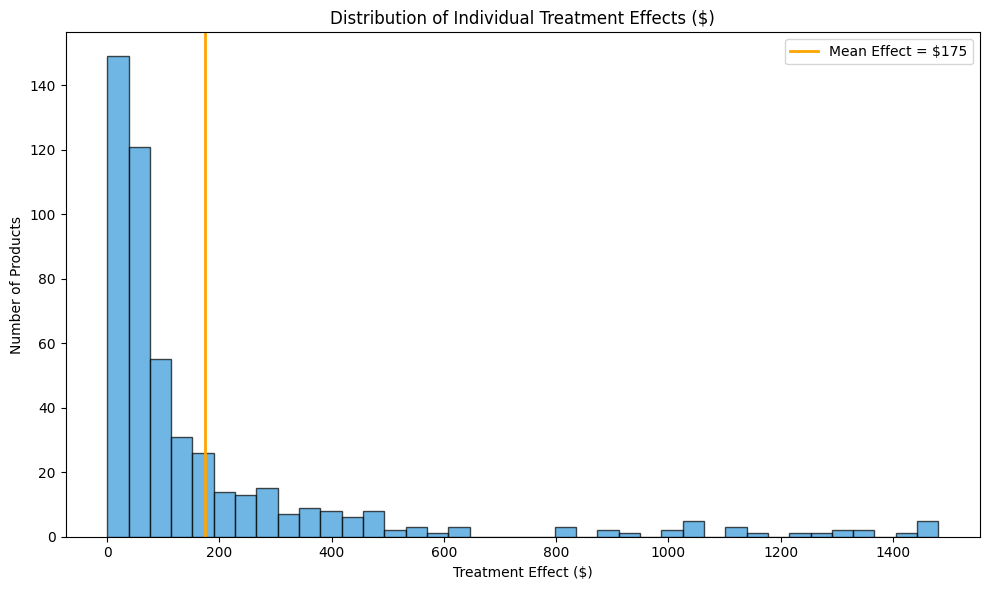

In [18]:
plot_individual_effects_distribution(
    full_info_df["delta"],
    title="Distribution of Individual Treatment Effects ($)",
)

## Population-Level Parameters

Since we cannot observe individual effects in practice, we focus on population averages:

| Parameter | Definition | Question Answered |
|-----------|------------|-------------------|
| **ATE** | $E[Y^1 - Y^0]$ | Average effect across ALL products |
| **ATT** | $E[Y^1 - Y^0 \mid D=1]$ | Effect among products that WERE treated |
| **ATC** | $E[Y^1 - Y^0 \mid D=0]$ | Effect if we treated the remaining products |

In [19]:
# True population parameters (we know both potential outcomes)
ATE_true = full_info_df["delta"].mean()

print(f"True ATE: ${ATE_true:,.2f}")
print("\nThis represents the average revenue increase from content optimization.")

True ATE: $174.52

This represents the average revenue increase from content optimization.


### Add Quality Score

We add a quality score that represents existing content quality. Higher quality products tend to have higher baseline revenue (realistic assumption: good content drives sales).

In [17]:
Code(inspect.getsource(generate_quality_score), language="python")

def generate_quality_score(revenue, seed=42, noise_std=0.5):
    """
    Generate quality score correlated with revenue.

    Higher revenue products get higher quality scores (realistic assumption:
    good content quality drives higher sales).

    Args:
        revenue: Series or array of baseline revenue values
        seed: Random seed for reproducibility
        noise_std: Standard deviation of noise (default 0.5)

    Returns:
        Array of quality scores in range [1, 5]
    """
    np.random.seed(seed)

    # Normalize revenue to 0-1 range
    revenue_min = revenue.min()
    revenue_max = revenue.max()
    revenue_normalized = (revenue - revenue_min) / (revenue_max - revenue_min + 1e-6)

    # Map to 1-5 scale with noise
    quality = 1 + 4 * revenue_normalized + np.random.normal(0, noise_std, len(revenue))

    return np.clip(quality, 1, 5).round(1)

Now we are ready to add it to our simulation setup.

In [18]:
df["quality_score"] = generate_quality_score(df["Y_baseline"])
df.head()

KeyError: 'Y_baseline'

In [ ]:
print(
    f"Quality score range: {df['quality_score'].min():.1f} - {df['quality_score'].max():.1f}"
)
print(f"Mean quality: {df['quality_score'].mean():.2f}")
print(
    f"Correlation(quality, revenue): {df['quality_score'].corr(df['Y_baseline']):.2f}"
)

### Heterogeneous Effects: ATE ≠ ATT ≠ ATC

When treatment effects vary across products, the three parameters differ based on which products are treated.

In [ ]:
# Suppose we treat HIGH QUALITY products (top 30%)
n_treat = int(len(df) * 0.3)
treated_ids = set(df.nlargest(n_treat, "quality_score")["asin"])
df["D"] = df["asin"].isin(treated_ids).astype(int)

# Calculate parameters under this treatment assignment
ATE = df["delta"].mean()
ATT = df[df["D"] == 1]["delta"].mean()
ATC = df[df["D"] == 0]["delta"].mean()

print("With quality-based treatment selection:")
print(f"  ATE: ${ATE:,.2f}  (average effect for ALL products)")
print(f"  ATT: ${ATT:,.2f}  (effect for TREATED products - high quality)")
print(f"  ATC: ${ATC:,.2f}  (effect for CONTROL products - low quality)")
print(
    "\nNote: ATT < ATE < ATC because high-quality products benefit LESS from optimization."
)

In [ ]:
plot_treatment_parameters(
    ATE,
    ATT,
    ATC,
    title="Population-Level Treatment Parameters (Quality-Based Selection)",
)

## Selection Bias

The **naive estimator** compares average outcomes between treated and control groups:

$$\hat{\delta}_{NAIVE} = E[Y \mid D=1] - E[Y \mid D=0]$$

This equals the ATE only if treatment is independent of potential outcomes. In practice, businesses don't randomly select products—they prioritize high-quality products for optimization.

### Our Selection Mechanism

We treat the **top 30% by quality score**. This creates selection bias because:
- High quality → higher baseline revenue (Y⁰)
- High quality → smaller treatment effect (δ)

In [ ]:
# Observed outcome follows the switching equation
df["Y"] = np.where(df["D"] == 1, df["Y_1"], df["Y_0"])

# Naive estimate
treated_mean = df[df["D"] == 1]["Y"].mean()
control_mean = df[df["D"] == 0]["Y"].mean()
naive_estimate = treated_mean - control_mean

print(f"Mean revenue (Treated):  ${treated_mean:,.2f}")
print(f"Mean revenue (Control):  ${control_mean:,.2f}")
print(f"\nNaive estimate:          ${naive_estimate:,.2f}")
print(f"True ATE:                ${ATE_true:,.2f}")
print(f"\nBias: ${naive_estimate - ATE_true:,.2f}")

In [ ]:
plot_outcome_by_treatment(
    df[df["D"] == 1]["Y"],
    df[df["D"] == 0]["Y"],
    title="Outcome Distribution: Quality-Based Selection (High Quality Treated)",
)

### Bias Decomposition

The naive estimate includes both the true treatment effect AND selection bias:

$$\text{Naive} - \text{ATE} = \underbrace{E[Y^0 \mid D=1] - E[Y^0 \mid D=0]}_{\text{Baseline Bias}} + \underbrace{E[\delta \mid D=1] - E[\delta]}_{\text{Selection on Gains}}$$

- **Baseline bias**: Treated products would have higher revenue *even without treatment*
- **Selection on gains**: Treated products have *smaller* treatment effects

In [ ]:
# Calculate bias components
baseline_treated = df[df["D"] == 1]["Y_0"].mean()
baseline_control = df[df["D"] == 0]["Y_0"].mean()
baseline_bias = baseline_treated - baseline_control

selection_on_gains = ATT - ATE

print("Bias Decomposition:")
print(f"  Baseline bias:       +${baseline_bias:,.2f}  (treated have higher Y^0)")
print(
    f"  Selection on gains:  ${selection_on_gains:,.2f}  (treated have smaller delta)"
)
print("  ─────────────────────────────")
print(f"  Total bias:          ${baseline_bias + selection_on_gains:,.2f}")
print(f"\nNaive - ATE:           ${naive_estimate - ATE_true:,.2f}")
print("\nConclusion: Baseline bias DOMINATES -> naive estimate OVERESTIMATES")

In [ ]:
plot_bias_decomposition(
    ate=ATE_true,
    baseline_bias=baseline_bias,
    selection_on_gains=selection_on_gains,
    naive_estimate=naive_estimate,
    title="Bias Decomposition: Quality-Based Selection",
)

### Checking Covariate Balance

A key diagnostic is checking **covariate balance**—treated and control groups should have similar distributions of baseline characteristics if selection is random.

In [ ]:
plot_balance_check(
    df,
    covariates=["quality_score", "Y_0"],
    treatment_col="D",
    title="Covariate Balance: Quality-Based Selection (IMBALANCED)",
)

## Randomization as the Solution

Randomization breaks the link between treatment assignment and potential outcomes:

$$(Y^0, Y^1) \perp\!\!\!\perp D$$

Under randomization, the naive estimator is unbiased:

$$E[Y \mid D=1] - E[Y \mid D=0] = E[Y^1] - E[Y^0] = \text{ATE}$$

In [ ]:
# Random treatment assignment
np.random.seed(456)
df["D_random"] = np.random.binomial(1, 0.3, len(df))
df["Y_random"] = np.where(df["D_random"] == 1, df["Y_1"], df["Y_0"])

# Naive estimate under random assignment
treated_mean_random = df[df["D_random"] == 1]["Y_random"].mean()
control_mean_random = df[df["D_random"] == 0]["Y_random"].mean()
naive_random = treated_mean_random - control_mean_random

print("Random Selection:")
print(f"  Mean revenue (Treated):  ${treated_mean_random:,.2f}")
print(f"  Mean revenue (Control):  ${control_mean_random:,.2f}")
print(f"  Naive estimate:          ${naive_random:,.2f}")
print(f"  True ATE:                ${ATE_true:,.2f}")
print(f"  Bias:                    ${naive_random - ATE_true:,.2f}")

In [ ]:
plot_balance_check(
    df,
    covariates=["quality_score", "Y_0"],
    treatment_col="D_random",
    title="Covariate Balance: Random Selection (BALANCED)",
)

### Monte Carlo Comparison

Let's run multiple simulations to see the distribution of estimates under random vs quality-based selection.

In [ ]:
# Monte Carlo simulation
n_simulations = 500
n_treat = int(len(df) * 0.3)

random_estimates = []
biased_estimates = []

for i in range(n_simulations):
    # Random selection
    random_idx = np.random.choice(len(df), n_treat, replace=False)
    D_random = np.zeros(len(df))
    D_random[random_idx] = 1
    Y_random = np.where(D_random == 1, df["Y_1"], df["Y_0"])
    est_random = Y_random[D_random == 1].mean() - Y_random[D_random == 0].mean()
    random_estimates.append(est_random)

    # Quality-based selection (top performers)
    top_idx = df.nlargest(n_treat, "quality_score").index
    D_biased = np.zeros(len(df))
    D_biased[top_idx] = 1
    Y_biased = np.where(D_biased == 1, df["Y_1"], df["Y_0"])
    est_biased = Y_biased[D_biased == 1].mean() - Y_biased[D_biased == 0].mean()
    biased_estimates.append(est_biased)

print(
    f"Random selection:  Mean = ${np.mean(random_estimates):,.0f}, Std = ${np.std(random_estimates):,.0f}"
)
print(
    f"Quality selection: Mean = ${np.mean(biased_estimates):,.0f}, Std = ${np.std(biased_estimates):,.0f}"
)
print(f"True ATE:          ${ATE_true:,.0f}")

In [ ]:
plot_randomization_comparison(random_estimates, biased_estimates, ATE_true)

## Bootstrap for Uncertainty Quantification

With randomized data, we can use bootstrap to quantify uncertainty in our estimate.

In [ ]:
# Bootstrap estimation using random assignment data
np.random.seed(789)
n_bootstrap = 500
bootstrap_estimates = []

treated_outcomes = df[df["D_random"] == 1]["Y_random"].values
control_outcomes = df[df["D_random"] == 0]["Y_random"].values

for _ in range(n_bootstrap):
    treated_sample = np.random.choice(
        treated_outcomes, len(treated_outcomes), replace=True
    )
    control_sample = np.random.choice(
        control_outcomes, len(control_outcomes), replace=True
    )
    estimate = treated_sample.mean() - control_sample.mean()
    bootstrap_estimates.append(estimate)

ci_low, ci_high = plot_bootstrap_distribution(
    bootstrap_estimates,
    true_ate=ATE_true,
    title="Bootstrap Distribution of Treatment Effect (Random Assignment)",
)

print(f"\n95% Confidence Interval: [${ci_low:,.0f}, ${ci_high:,.0f}]")

## SUTVA: Stable Unit Treatment Value Assumption

The potential outcome framework relies on SUTVA:

1. **No interference**: One product's treatment doesn't affect another product's outcomes
2. **No hidden variations**: Treatment is well-defined (no multiple versions)

### Potential SUTVA Violations in E-commerce

| Violation | Example | Implication |
|-----------|---------|-------------|
| **Cannibalization** | Better content on Product A steals sales from Product B | Interference between products |
| **Market saturation** | If ALL products are optimized, relative advantage disappears | Effect depends on treatment prevalence |
| **Budget constraints** | Customers have fixed budgets; more on A means less on B | Zero-sum dynamics |